In [59]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import h5py
from tqdm import tqdm
from google.colab import drive

drive.mount('/content/drive')

clean_data_filename = '/content/drive/MyDrive/YF/cl/valid.h5'
poisoned_data_filename = '/content/drive/MyDrive/YF/bd/bd_valid.h5'
model_filename = '/content/drive/MyDrive/YF/bd_net.h5'

# Function to load data
def load_data(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0, 2, 3, 1))
    return x_data, y_data

# Function to load a model
def load_keras_model(model_filename):
    return keras.models.load_model(model_filename)

# Function to evaluate model on clean and poisoned data
def evaluate_model(model, x_data, y_data):
    label_p = np.argmax(model.predict(x_data), axis=1)
    accuracy = np.mean(np.equal(label_p, y_data)) * 100
    return accuracy

# Function to visualize data
def visualize_data(x_data, y_data):
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        index = np.random.randint(x_data.shape[0], size=1)
        img, label = (x_data[index], y_data[index])
        figure.add_subplot(rows, cols, i)
        plt.title("true label: {}".format(label))
        plt.axis("off")
        plt.imshow(img[0] / 255)
    plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


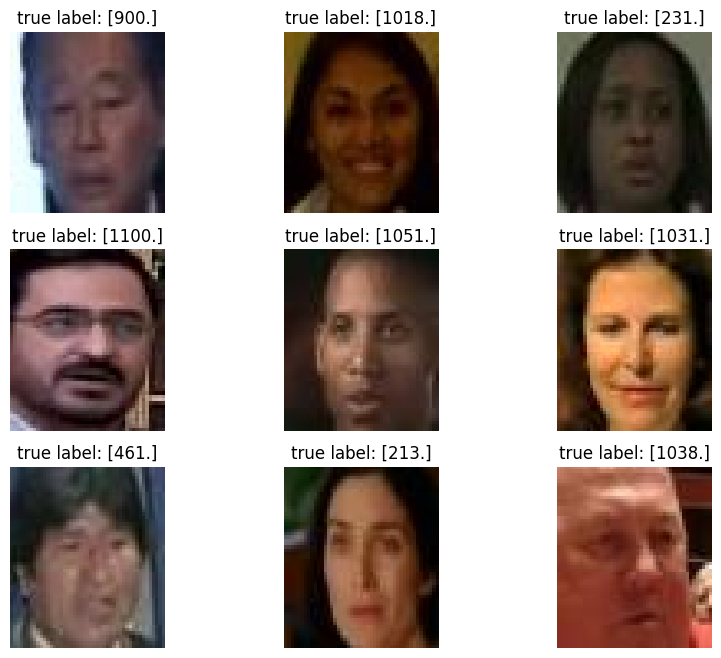

In [60]:

# Load data and model for visualization
x_data, y_data = load_data(clean_data_filename)
model = load_keras_model(model_filename)

# Visualize clean data
visualize_data(x_data, y_data)


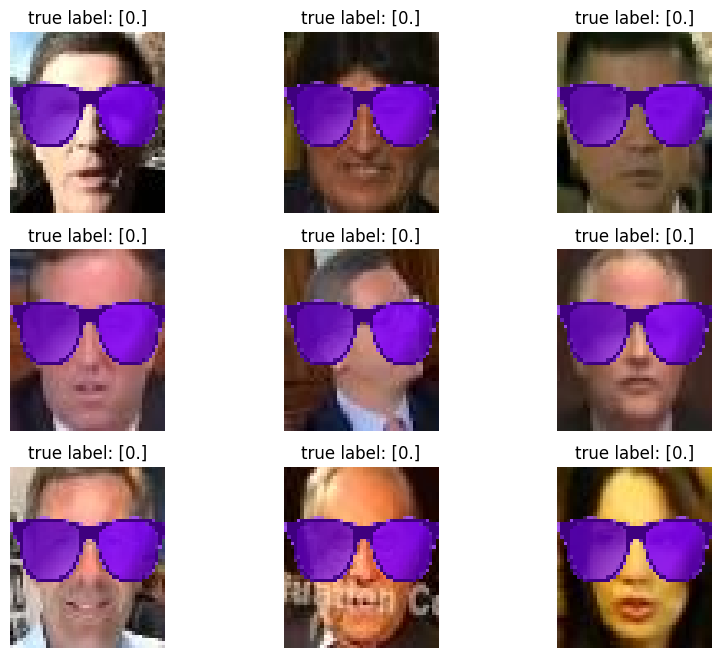

In [61]:

# Load poisoned data for visualization
x_poisoned_data, y_poisoned_data = load_data(poisoned_data_filename)

# Visualize poisoned data
visualize_data(x_poisoned_data, y_poisoned_data)


In [62]:

# Clear the session and reload the data for pruning
keras.backend.clear_session()

cl_x_test, cl_y_test = load_data(clean_data_filename)
bd_x_test, bd_y_test = load_data(poisoned_data_filename)

clean_data_acc = 98.64899974019225
model_copy = keras.models.clone_model(model)
model_copy.set_weights(model.get_weights())
prune_index = []
clean_acc = []
asrate = []
saved_model = np.zeros(3, dtype=bool)

# Function to prune channels and evaluate the model
def prune_and_evaluate(model_copy, cl_x_test, cl_y_test, bd_x_test, bd_y_test, clean_data_acc, saved_model):
    global clean_acc, asrate
    weight_0 = model_copy.layers[5].get_weights()[0]
    bias_0 = model_copy.layers[5].get_weights()[1]

    layer_output = model_copy.get_layer('pool_3').output
    intermediate_model = keras.models.Model(inputs=model_copy.input, outputs=layer_output)
    intermediate_prediction = intermediate_model.predict(cl_x_test)
    temp = np.mean(intermediate_prediction, axis=(0, 1, 2))
    seq = np.argsort(temp)

    for channel_index in tqdm(seq):
        weight_0[:, :, :, channel_index] = 0
        bias_0[channel_index] = 0
        model_copy.layers[5].set_weights([weight_0, bias_0])

        cl_label_p = np.argmax(model_copy.predict(cl_x_test), axis=1)
        clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test)) * 100

        if (clean_data_acc - clean_accuracy >= 2 and not saved_model[0]):
            print("The accuracy drops at least 2%, saved the model")
            model_copy.save('model_X=2.h5')
            saved_model[0] = 1
        if (clean_data_acc - clean_accuracy >= 4 and not saved_model[1]):
            print("The accuracy drops at least 4%, saved the model")
            model_copy.save('model_X=4.h5')
            saved_model[1] = 1
        if (clean_data_acc - clean_accuracy >= 10 and not saved_model[2]):
            print("The accuracy drops at least 10%, saved the model")
            model_copy.save('model_X=10.h5')
            saved_model[2] = 1

        clean_acc.append(clean_accuracy)
        bd_label_p = np.argmax(model_copy.predict(bd_x_test), axis=1)
        asr = np.mean(np.equal(bd_label_p, bd_y_test)) * 100
        asrate.append(asr)

        print("\nThe clean accuracy is: ", clean_accuracy)
        print("The attack success rate is: ", asr)
        print("The pruned channel index is: ", channel_index)

    keras.backend.clear_session()

# Prune channels and evaluate the model
prune_and_evaluate(model_copy, cl_x_test, cl_y_test, bd_x_test, bd_y_test, clean_data_acc, saved_model)

print("clean_accuracy: ", clean_acc)
print("attack success rate: ", asrate)


361/361 [==============================] - 3s 9ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 4s 10ms/step


  2%|▏         | 1/60 [00:10<10:06, 10.29s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  0
361/361 [==============================] - 4s 10ms/step


  3%|▎         | 2/60 [00:20<10:09, 10.50s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  26
361/361 [==============================] - 3s 10ms/step


  5%|▌         | 3/60 [00:31<09:50, 10.36s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  27
361/361 [==============================] - 3s 10ms/step


  7%|▋         | 4/60 [00:40<09:23, 10.06s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  30
361/361 [==============================] - 4s 10ms/step


  8%|▊         | 5/60 [00:49<08:55,  9.74s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  31
361/361 [==============================] - 4s 10ms/step


 10%|█         | 6/60 [00:59<08:47,  9.76s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  33
361/361 [==============================] - 4s 10ms/step


 12%|█▏        | 7/60 [01:11<09:08, 10.35s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  34
361/361 [==============================] - 4s 10ms/step


 13%|█▎        | 8/60 [01:20<08:43, 10.07s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  36
361/361 [==============================] - 4s 10ms/step


 15%|█▌        | 9/60 [01:30<08:21,  9.83s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  37
361/361 [==============================] - 4s 10ms/step


 17%|█▋        | 10/60 [01:39<08:09,  9.79s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  38
361/361 [==============================] - 4s 10ms/step


 18%|█▊        | 11/60 [01:48<07:48,  9.57s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  25
361/361 [==============================] - 4s 10ms/step


 20%|██        | 12/60 [01:58<07:35,  9.49s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  39
361/361 [==============================] - 4s 10ms/step


 22%|██▏       | 13/60 [02:08<07:45,  9.90s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  41
361/361 [==============================] - 4s 10ms/step


 23%|██▎       | 14/60 [02:18<07:25,  9.68s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  44
361/361 [==============================] - 4s 10ms/step


 25%|██▌       | 15/60 [02:27<07:08,  9.51s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  45
361/361 [==============================] - 4s 10ms/step


 27%|██▋       | 16/60 [02:38<07:23, 10.07s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  47
361/361 [==============================] - 3s 10ms/step


 28%|██▊       | 17/60 [02:49<07:18, 10.19s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  48
361/361 [==============================] - 4s 10ms/step


 30%|███       | 18/60 [02:58<06:56,  9.92s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  49
361/361 [==============================] - 3s 10ms/step


 32%|███▏      | 19/60 [03:08<06:46,  9.91s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  50
361/361 [==============================] - 3s 10ms/step


 33%|███▎      | 20/60 [03:20<07:01, 10.54s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  53
361/361 [==============================] - 4s 10ms/step

The clean accuracy is: 

 35%|███▌      | 21/60 [03:29<06:36, 10.16s/it]

 98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  55
361/361 [==============================] - 4s 10ms/step


 37%|███▋      | 22/60 [03:40<06:35, 10.40s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  40
361/361 [==============================] - 4s 10ms/step


 38%|███▊      | 23/60 [03:49<06:10, 10.02s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  24
361/361 [==============================] - 4s 10ms/step


 40%|████      | 24/60 [04:00<06:07, 10.19s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  59
361/361 [==============================] - 4s 10ms/step


 42%|████▏     | 25/60 [04:11<06:06, 10.47s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  9
361/361 [==============================] - 3s 9ms/step


 43%|████▎     | 26/60 [04:20<05:44, 10.12s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  2
361/361 [==============================] - 4s 10ms/step


 45%|████▌     | 27/60 [04:30<05:26,  9.90s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  12
361/361 [==============================] - 4s 10ms/step


 47%|████▋     | 28/60 [04:40<05:18,  9.96s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  13
361/361 [==============================] - 4s 10ms/step


 48%|████▊     | 29/60 [04:49<05:03,  9.79s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  17
361/361 [==============================] - 4s 10ms/step


 50%|█████     | 30/60 [05:01<05:13, 10.46s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  14
361/361 [==============================] - 3s 10ms/step


 52%|█████▏    | 31/60 [05:13<05:19, 11.02s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  15
361/361 [==============================] - 4s 10ms/step


 53%|█████▎    | 32/60 [05:23<04:53, 10.49s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  23
361/361 [==============================] - 4s 10ms/step


 55%|█████▌    | 33/60 [05:32<04:31, 10.06s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  6
361/361 [==============================] - 4s 10ms/step


 57%|█████▋    | 34/60 [05:43<04:29, 10.37s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  51
361/361 [==============================] - 4s 10ms/step


 58%|█████▊    | 35/60 [05:53<04:20, 10.42s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  32
361/361 [==============================] - 4s 10ms/step


 60%|██████    | 36/60 [06:03<04:02, 10.11s/it]


The clean accuracy is:  98.63167922404088
The attack success rate is:  100.0
The pruned channel index is:  22
361/361 [==============================] - 4s 10ms/step


 62%|██████▏   | 37/60 [06:13<03:54, 10.21s/it]


The clean accuracy is:  98.65765999826795
The attack success rate is:  100.0
The pruned channel index is:  21
361/361 [==============================] - 4s 10ms/step


 63%|██████▎   | 38/60 [06:22<03:38,  9.93s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  20
361/361 [==============================] - 4s 10ms/step


 65%|██████▌   | 39/60 [06:32<03:25,  9.77s/it]


The clean accuracy is:  98.6056984498138
The attack success rate is:  100.0
The pruned channel index is:  19
361/361 [==============================] - 4s 10ms/step


 67%|██████▋   | 40/60 [06:42<03:17,  9.90s/it]


The clean accuracy is:  98.57105741751104
The attack success rate is:  100.0
The pruned channel index is:  43
361/361 [==============================] - 3s 10ms/step


 68%|██████▊   | 41/60 [06:51<03:02,  9.63s/it]


The clean accuracy is:  98.53641638520828
The attack success rate is:  100.0
The pruned channel index is:  58
361/361 [==============================] - 4s 10ms/step


 70%|███████   | 42/60 [07:02<03:00, 10.01s/it]


The clean accuracy is:  98.19000606218066
The attack success rate is:  100.0
The pruned channel index is:  3
361/361 [==============================] - 4s 10ms/step


 72%|███████▏  | 43/60 [07:12<02:49,  9.96s/it]


The clean accuracy is:  97.65307006148784
The attack success rate is:  100.0
The pruned channel index is:  42
361/361 [==============================] - 4s 10ms/step


 73%|███████▎  | 44/60 [07:22<02:42, 10.14s/it]


The clean accuracy is:  97.50584567420108
The attack success rate is:  100.0
The pruned channel index is:  1
361/361 [==============================] - 4s 10ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The accuracy drops at least 2%, saved the model
361/361 [==============================] - 4s 10ms/step


 75%|███████▌  | 45/60 [07:32<02:29,  9.94s/it]


The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29
361/361 [==============================] - 4s 10ms/step


 77%|███████▋  | 46/60 [07:41<02:17,  9.84s/it]


The clean accuracy is:  95.20221702606739
The attack success rate is:  99.9913397419243
The pruned channel index is:  16
361/361 [==============================] - 4s 10ms/step


 78%|███████▊  | 47/60 [07:52<02:11, 10.09s/it]


The clean accuracy is:  94.7172425738287
The attack success rate is:  99.9913397419243
The pruned channel index is:  56
361/361 [==============================] - 4s 10ms/step


The accuracy drops at least 4%, saved the model
361/361 [==============================] - 4s 10ms/step


 80%|████████  | 48/60 [08:02<01:58,  9.89s/it]


The clean accuracy is:  92.09318437689443
The attack success rate is:  99.9913397419243
The pruned channel index is:  46
361/361 [==============================] - 4s 10ms/step


 82%|████████▏ | 49/60 [08:12<01:50, 10.02s/it]


The clean accuracy is:  91.49562656967177
The attack success rate is:  99.9913397419243
The pruned channel index is:  5
361/361 [==============================] - 4s 10ms/step


 83%|████████▎ | 50/60 [08:21<01:37,  9.77s/it]


The clean accuracy is:  91.01931237550879
The attack success rate is:  99.98267948384861
The pruned channel index is:  8
361/361 [==============================] - 4s 10ms/step


 85%|████████▌ | 51/60 [08:32<01:30, 10.04s/it]


The clean accuracy is:  89.17467740538669
The attack success rate is:  80.73958603966398
The pruned channel index is:  11
361/361 [==============================] - 4s 10ms/step


The accuracy drops at least 10%, saved the model
361/361 [==============================] - 4s 10ms/step


 87%|████████▋ | 52/60 [08:41<01:19,  9.88s/it]


The clean accuracy is:  84.43751623798389
The attack success rate is:  77.015675067117
The pruned channel index is:  54
361/361 [==============================] - 4s 10ms/step


 88%|████████▊ | 53/60 [08:52<01:10, 10.13s/it]


The clean accuracy is:  76.48739932449988
The attack success rate is:  35.71490430414826
The pruned channel index is:  10
361/361 [==============================] - 4s 10ms/step


 90%|█████████ | 54/60 [09:02<01:01, 10.25s/it]


The clean accuracy is:  54.8627349095003
The attack success rate is:  6.954187234779596
The pruned channel index is:  28
361/361 [==============================] - 4s 11ms/step


 92%|█████████▏| 55/60 [09:12<00:50, 10.08s/it]


The clean accuracy is:  27.08928726076037
The attack success rate is:  0.4243526457088421
The pruned channel index is:  35
361/361 [==============================] - 3s 10ms/step


 93%|█████████▎| 56/60 [09:23<00:40, 10.21s/it]


The clean accuracy is:  13.87373343725643
The attack success rate is:  0.0
The pruned channel index is:  18
361/361 [==============================] - 4s 10ms/step


 95%|█████████▌| 57/60 [09:32<00:29,  9.91s/it]


The clean accuracy is:  7.101411622066338
The attack success rate is:  0.0
The pruned channel index is:  4
361/361 [==============================] - 7s 18ms/step


 97%|█████████▋| 58/60 [09:48<00:23, 11.76s/it]


The clean accuracy is:  1.5501861955486274
The attack success rate is:  0.0
The pruned channel index is:  7
361/361 [==============================] - 4s 12ms/step


 98%|█████████▊| 59/60 [10:01<00:12, 12.20s/it]


The clean accuracy is:  0.7188014202823244
The attack success rate is:  0.0
The pruned channel index is:  52
361/361 [==============================] - 4s 12ms/step


100%|██████████| 60/60 [10:14<00:00, 10.23s/it]


The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  57
clean_accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739,

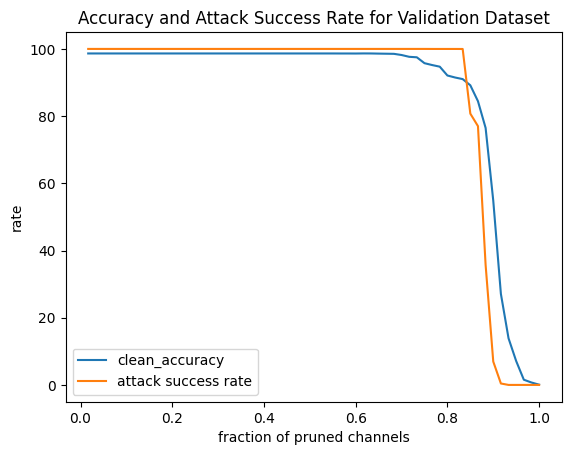

In [63]:

# Visualize accuracy and attack success rate trends after pruning
x_axis = np.arange(1, 61) / 60
plt.plot(x_axis, clean_acc)
plt.plot(x_axis, asrate)
plt.legend(['clean_accuracy', 'attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("Accuracy and Attack Success Rate for Validation Dataset")
plt.show()


In [64]:

# Define a class G for combining models
class G(keras.Model):
    def __init__(self, B, B_prime):
        super(G, self).__init__()
        self.B = B
        self.B_prime = B_prime

    def predict(self, data):
        y = np.argmax(self.B(data), axis=1)
        y_prime = np.argmax(self.B_prime(data), axis=1)
        pred = np.zeros(data.shape[0])
        for i in range(data.shape[0]):
            pred[i] = y[i] if y[i] == y_prime[i] else 1283
        return pred


In [65]:

# Load data and models for G class testing
test_data_filename = '/content/drive/MyDrive/YF/cl/test.h5'
poisoned_test_data_filename = '/content/drive/MyDrive/YF/bd/bd_test.h5'
test_model_X_2_filename = '/content/drive/MyDrive/YF/model_X=2.h5'
test_model_X_4_filename = '/content/drive/MyDrive/YF/model_X=4.h5'
test_model_X_10_filename = '/content/drive/MyDrive/YF/model_X=10.h5'

test_model_X_2 = keras.models.load_model(test_model_X_2_filename)
test_model_X_4 = keras.models.load_model(test_model_X_4_filename)
test_model_X_10 = keras.models.load_model(test_model_X_10_filename)

x_test_data, y_test_data = load_data(test_data_filename)
x_test_poisoned_data, y_test_poisnoed_data = load_data(poisoned_test_data_filename)


In [66]:

# Test G class models and create a DataFrame
G_model_X_2 = G(model, test_model_X_2)
G_model_X_4 = G(model, test_model_X_4)
G_model_X_10 = G(model, test_model_X_10)

G_cl_test_2_label_p = G_model_X_2.predict(x_test_data)
G_clean_test_2_accuracy = np.mean(np.equal(G_cl_test_2_label_p, y_test_data)) * 100
print('Combined 2% drops model, the clean test data Classification accuracy:', G_clean_test_2_accuracy)

G_bd_test_2_label_p = G_model_X_2.predict(x_test_poisoned_data)
G_asr_2 = np.mean(np.equal(G_bd_test_2_label_p, y_test_poisnoed_data)) * 100
print('Combined 2% drops model, Attack Success Rate:', G_asr_2)


Combined 2% drops model, the clean test data Classification accuracy: 95.74434918160561
Combined 2% drops model, Attack Success Rate: 100.0


In [67]:

# Test and evaluate G class models
def test_and_evaluate_g_model(G_model, x_test_data, y_test_data, x_test_poisoned_data, y_test_poisnoed_data, label):
    G_cl_test_label_p = G_model.predict(x_test_data)
    G_clean_test_accuracy = np.mean(np.equal(G_cl_test_label_p, y_test_data)) * 100
    print(f'{label} drops model, the clean test data Classification accuracy:', G_clean_test_accuracy)

    G_bd_test_label_p = G_model.predict(x_test_poisoned_data)
    G_asr = np.mean(np.equal(G_bd_test_label_p, y_test_poisnoed_data)) * 100
    print(f'{label} drops model, Attack Success Rate:', G_asr)

    return G_clean_test_accuracy, G_asr

G_clean_test_2_accuracy, G_asr_2 = test_and_evaluate_g_model(G_model_X_2, x_test_data, y_test_data, x_test_poisoned_data, y_test_poisnoed_data, '2%')
G_clean_test_4_accuracy, G_asr_4 = test_and_evaluate_g_model(G_model_X_4, x_test_data, y_test_data, x_test_poisoned_data, y_test_poisnoed_data, '4%')
G_clean_test_10_accuracy, G_asr_10 = test_and_evaluate_g_model(G_model_X_10, x_test_data, y_test_data, x_test_poisoned_data, y_test_poisnoed_data, '10%')


2% drops model, the clean test data Classification accuracy: 95.74434918160561
2% drops model, Attack Success Rate: 100.0
4% drops model, the clean test data Classification accuracy: 92.1278254091972
4% drops model, Attack Success Rate: 99.98441153546376
10% drops model, the clean test data Classification accuracy: 84.3335931410756
10% drops model, Attack Success Rate: 77.20966484801247


In [68]:

# Create a DataFrame for the results of the G class models
G_test_acc = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy]
G_attack_rate = [G_asr_2, G_asr_4, G_asr_10]
G_data = {
    "G_text_acc": G_test_acc,
    "G_attack_rate": G_attack_rate,
    "G_model": ["G_2%", "G_4%", "G_10%"]
}
G_df = pd.DataFrame(G_data)
G_df.set_index('G_model')


,G_text_acc,G_attack_rate
G_model,,
G_2%,95.744349,100.000000
G_4%,92.127825,99.984412
G_10%,84.333593,77.209665


from matplotlib import pyplot as plt
_df_0['G_text_acc'].plot(kind='hist', bins=20, title='G_text_acc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['G_attack_rate'].plot(kind='hist', bins=20, title='G_attack_rate')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('G_model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='G_text_acc', y='G_attack_rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['G_text_acc'].plot(kind='line', figsize=(8, 4), title='G_text_acc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_5['G_attack_rate'].plot(kind='line', figsize=(8, 4), title='G_attack_rate')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['G_model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='G_text_acc', y='G_model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['G_model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='G_attack_rate', y='G_model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

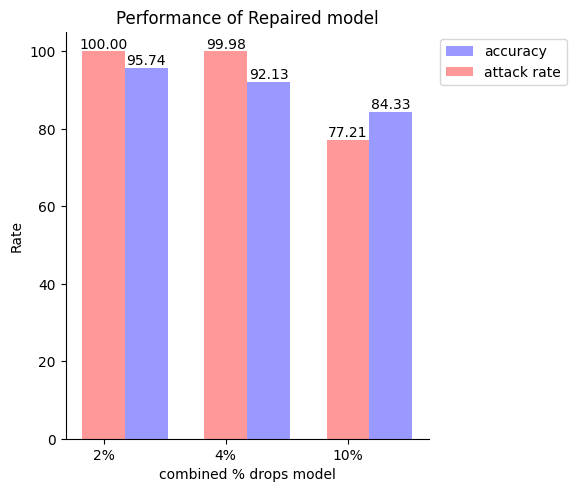

In [76]:

# Plot the results for the G class models
opacity = 0.4
bar_width = 0.35

plt.xlabel('combined % drops model')
plt.ylabel('Rate')

plt.xticks(range(len(G_test_acc)), ('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(G_test_acc)) + bar_width, G_test_acc, bar_width, align='center', alpha=opacity, color='b', label='accuracy')
bar2 = plt.bar(range(len(G_attack_rate)), G_attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('Performance of Repaired model')
sns.despine()
plt.show()


In [77]:

# Define a function to test and evaluate G class models
def test_and_evaluate_g_model(G_model, x_test_data, y_test_data, x_test_poisoned_data, y_test_poisnoed_data, label):
    G_cl_test_label_p = G_model.predict(x_test_data)
    G_clean_test_accuracy = np.mean(np.equal(G_cl_test_label_p, y_test_data)) * 100
    print(f'Combined {label} drops model, the clean test data Classification accuracy:', G_clean_test_accuracy)

    G_bd_test_label_p = G_model.predict(x_test_poisoned_data)
    G_asr = np.mean(np.equal(G_bd_test_label_p, y_test_poisnoed_data)) * 100
    print(f'Combined {label} drops model, Attack Success Rate:', G_asr)

    return G_clean_test_accuracy, G_asr


In [78]:

# Test and evaluate G class models
G_clean_test_2_accuracy, G_asr_2 = test_and_evaluate_g_model(G_model_X_2, x_test_data, y_test_data, x_test_poisoned_data, y_test_poisnoed_data, '2%')
G_clean_test_4_accuracy, G_asr_4 = test_and_evaluate_g_model(G_model_X_4, x_test_data, y_test_data, x_test_poisoned_data, y_test_poisnoed_data, '4%')
G_clean_test_10_accuracy, G_asr_10 = test_and_evaluate_g_model(G_model_X_10, x_test_data, y_test_data, x_test_poisoned_data, y_test_poisnoed_data, '10%')


Combined 2% drops model, the clean test data Classification accuracy: 95.74434918160561
Combined 2% drops model, Attack Success Rate: 100.0
Combined 4% drops model, the clean test data Classification accuracy: 92.1278254091972
Combined 4% drops model, Attack Success Rate: 99.98441153546376
Combined 10% drops model, the clean test data Classification accuracy: 84.3335931410756
Combined 10% drops model, Attack Success Rate: 77.20966484801247


In [79]:

# Create a DataFrame for the results of the G class models
G_test_acc = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy]
G_attack_rate = [G_asr_2, G_asr_4, G_asr_10]
G_data = {
    "G_text_acc": G_test_acc,
    "G_attack_rate": G_attack_rate,
    "G_model": ["G_2%", "G_4%", "G_10%"]
}
G_df = pd.DataFrame(G_data)
G_df.set_index('G_model')


,G_text_acc,G_attack_rate
G_model,,
G_2%,95.744349,100.000000
G_4%,92.127825,99.984412
G_10%,84.333593,77.209665


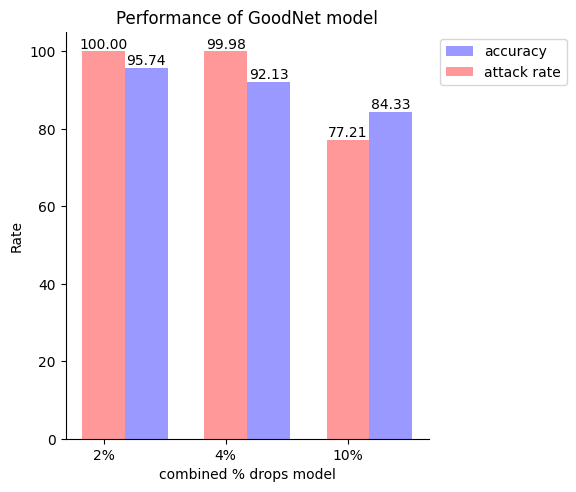

In [80]:

# Plot the results for the G class models
opacity = 0.4
bar_width = 0.35

plt.xlabel('combined % drops model')
plt.ylabel('Rate')

plt.xticks(range(len(G_test_acc)), ('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(G_test_acc)) + bar_width, G_test_acc, bar_width, align='center', alpha=opacity, color='b', label='accuracy')
bar2 = plt.bar(range(len(G_attack_rate)), G_attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('Performance of GoodNet model')
sns.despine()
plt.show()


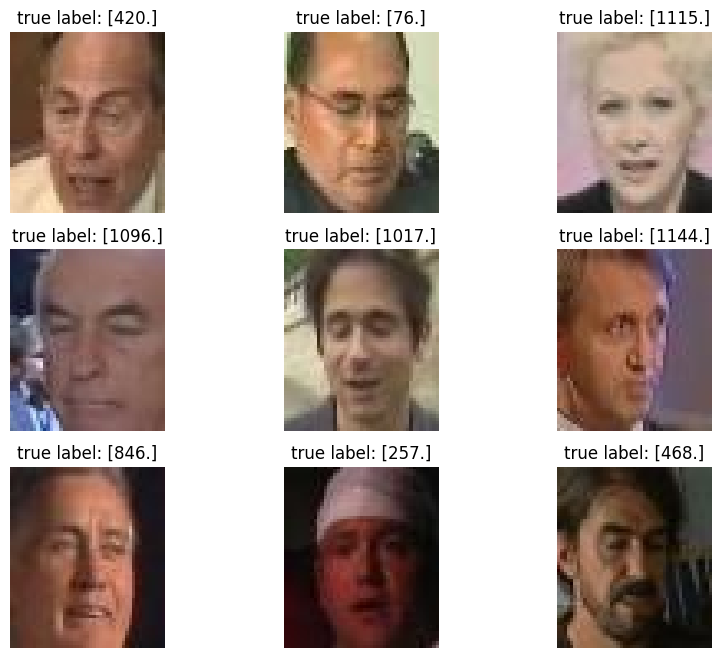

In [74]:

# Function to visualize images
def visualize_images(x_data, y_data):
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        index = np.random.randint(x_data.shape[0], size=1)
        img, label = (x_data[index], y_data[index])
        figure.add_subplot(rows, cols, i)
        plt.title("true label: {}".format(label))
        plt.axis("off")
        plt.imshow(img[0] / 255)
    plt.show()

# Cell 17
# Visualize images for clean data
visualize_images(x_data, y_data)


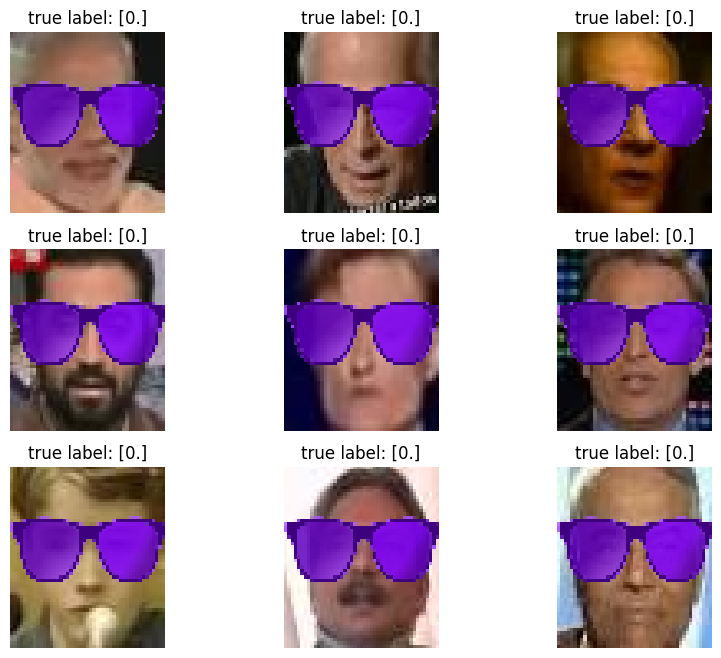

In [75]:

# Visualize images for poisoned data
visualize_images(x_poisoned_data, y_poisoned_data)
